# Investigating the KNN algorithm as an alternative classifier

In [1]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("../data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)


transform = v2.Compose(
    [
        v2.Resize(size=(400, 400)),
        v2.ToDtype(
            torch.float32, scale=True
        ),  # Use float32 datatype to enable training on Apple silicon GPU
        # v2.Grayscale(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

/Users/ivanbar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    test_size=0.2,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [4]:
from torch.utils.data import DataLoader, SubsetRandomSampler

dataset = RoastDefectsDataset(
    csv_file="../data/beans.csv",
    root_dir="../data/processed-whitebg",
    transform=transform,
)

train_sampler = SubsetRandomSampler(list(train.index))
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=len(train))
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=len(test))

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}

## Build datasets

In [7]:
X_train = []
y_train = []
X_test = []
y_test = []
for _, (data, label) in enumerate(train_loader):
    X_train = data.squeeze()
    y_train = label.squeeze()

for _, (data, label) in enumerate(test_loader):
    X_test = data.squeeze()
    y_test = label.squeeze()

## Dimensionality reduction - color histograms

(-0.5, 399.5, 399.5, -0.5)

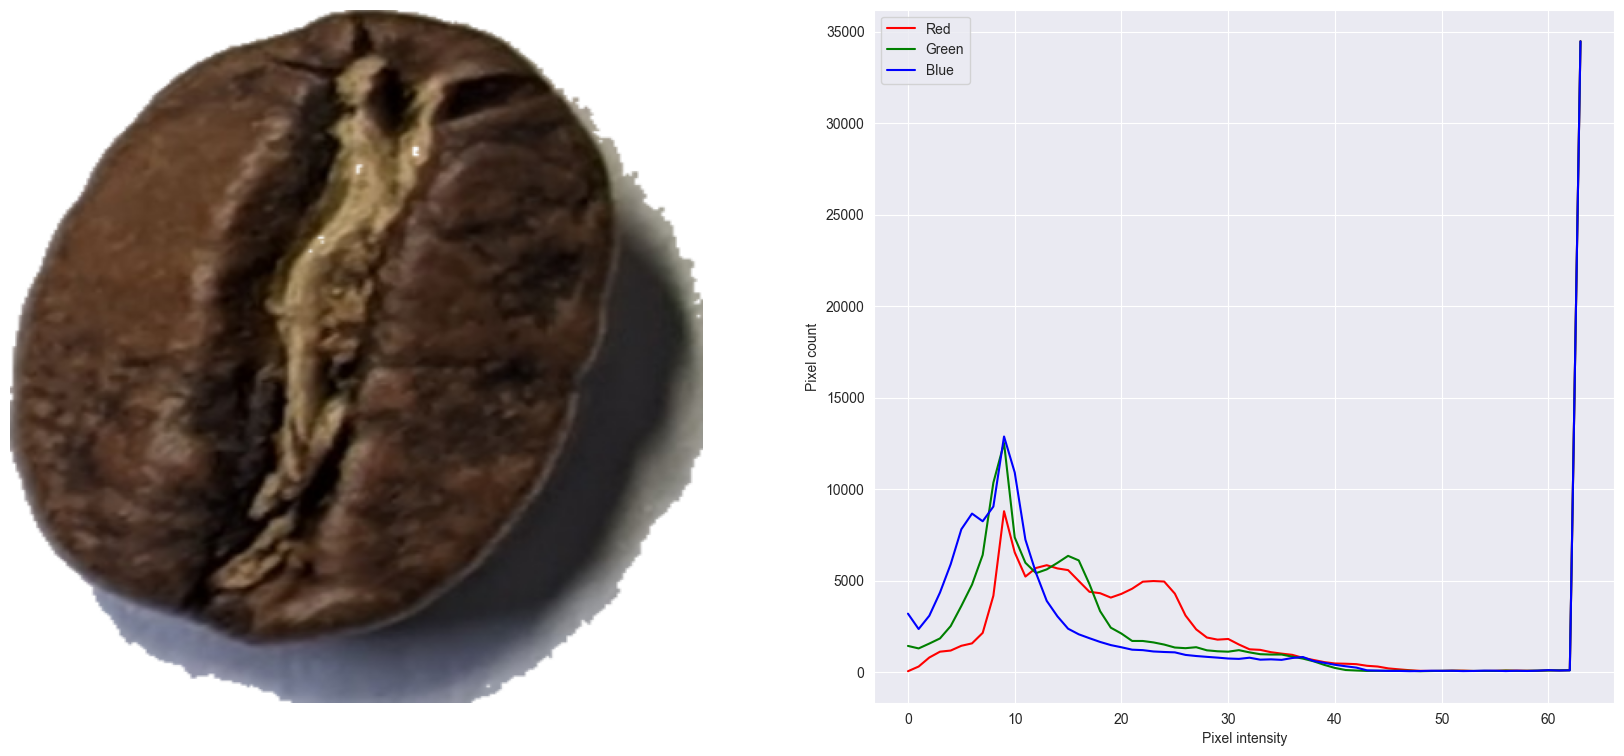

In [5]:
from skimage.exposure import histogram
from matplotlib import pyplot as plt

fig, (img_plot, hist_plot) = plt.subplots(1, 2, figsize=(21, 9))
sample_image = dataset[686][0]
hist, bins = histogram(sample_image.numpy(), nbins=64, channel_axis=0)
for index, channel in enumerate(hist):
    hist_plot.plot(
        channel,
        c=["red", "green", "blue"][index],
        label=["Red", "Green", "Blue"][index],
    )
hist_plot.legend()
hist_plot.set_xlabel("Pixel intensity")
hist_plot.set_ylabel("Pixel count")
img_plot.imshow(sample_image.permute(2, 1, 0))
img_plot.axis("off")
# plt.savefig("../report/figures/methodology/histogramExample.png", bbox_inches="tight")

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn_gridsearch = []
for bin_count in [32, 64, 128, 256]:
    X_train_hists = [
        histogram(img.numpy(), nbins=bin_count, channel_axis=0)[0].ravel()
        for img in X_train
    ]
    X_test_hists = [
        histogram(img.numpy(), nbins=bin_count, channel_axis=0)[0].ravel()
        for img in X_test
    ]
    for metric in ["manhattan", "canberra", "euclidean"]:
        for k in range(1, 30):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train_hists, y_train)
            preds = knn.predict(X_test_hists)
            accuracy = classification_report(
                y_test,
                preds,
                zero_division=0,
                target_names=DEFECT_CLASSES.keys(),
                output_dict=True,
            )["accuracy"]
            result = {"metric": metric, "k": k, "bins": bin_count, "acc": accuracy}
            knn_gridsearch.append(result)
            print(
                "Metric - ",
                metric,
                "K = ",
                k,
                "Bins - ",
                bin_count,
                "accuracy: ",
                accuracy,
            )

    # print(classification_report(y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys()))

KeyboardInterrupt: 

Average prediction time: 8.318ms
              precision    recall  f1-score   support

       burnt      0.571     0.400     0.471        10
      normal      0.797     0.958     0.870       263
        frag      0.800     0.271     0.405        59
       under      0.800     0.571     0.667        21
      quaker      0.802     0.806     0.804       196
insectOrMold      1.000     0.333     0.500         9

    accuracy                          0.797       558
   macro avg      0.795     0.557     0.619       558
weighted avg      0.799     0.797     0.777       558



<Axes: >

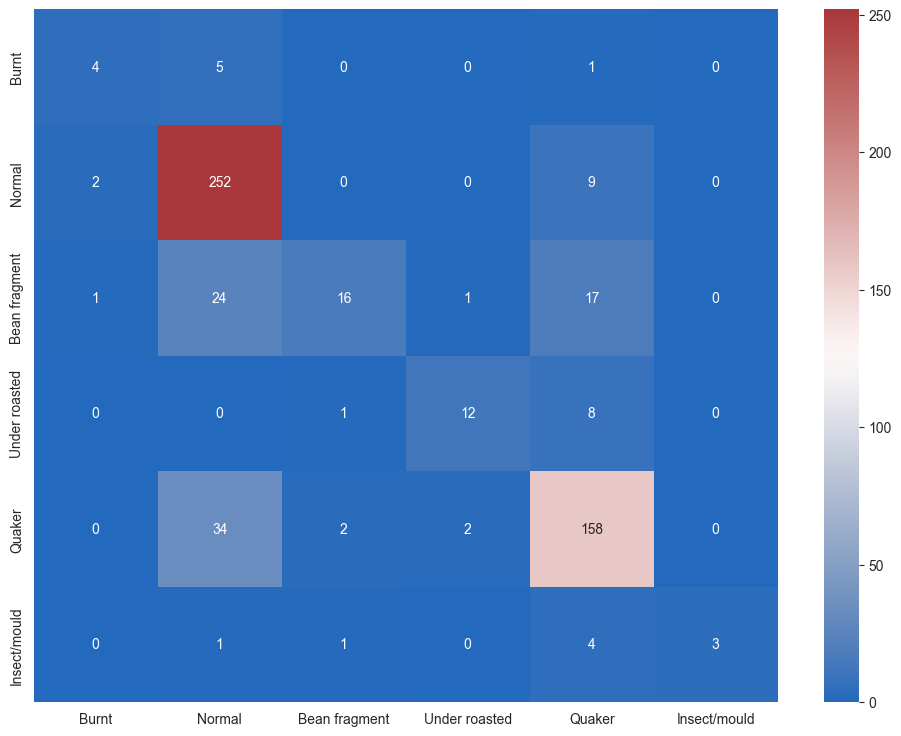

In [11]:
from torcheval.metrics import MulticlassConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

DEFECT_CLASSES_PRINT_NAMES = {
    "burnt": "Burnt",
    "normal": "Normal",
    "frag": "Bean fragment",
    "under": "Under roasted",
    "quaker": "Quaker",
    "insectOrMold": "Insect/mould",
}

X_train_hists = [
    histogram(img.numpy(), nbins=256, channel_axis=0)[0].ravel() for img in X_train
]
knn = KNeighborsClassifier(n_neighbors=6, metric="canberra")
knn.fit(X_train_hists, y_train)
start = datetime.now()
X_test_hists = [
    histogram(img.numpy(), nbins=256, channel_axis=0)[0].ravel() for img in X_test
]


preds = knn.predict(X_test_hists)
end = datetime.now()
print(
    f"Average prediction time: {round(((end - start).total_seconds() / len(y_test)) * 1000, 3)}ms"
)
print(
    classification_report(
        y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys(), digits=3
    )
)

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(preds), y_test)

confs = matrix.compute()


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    yticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)
# plt.savefig("../report/figures/confusionMatrices/KNN-2.png")

              precision    recall  f1-score   support

       burnt      1.000     0.200     0.333        10
      normal      0.809     0.951     0.874       263
        frag      0.688     0.186     0.293        59
       under      0.833     0.238     0.370        21
      quaker      0.742     0.852     0.793       196
insectOrMold      0.000     0.000     0.000         9

    accuracy                          0.780       558
   macro avg      0.679     0.405     0.444       558
weighted avg      0.764     0.780     0.742       558



<Axes: >

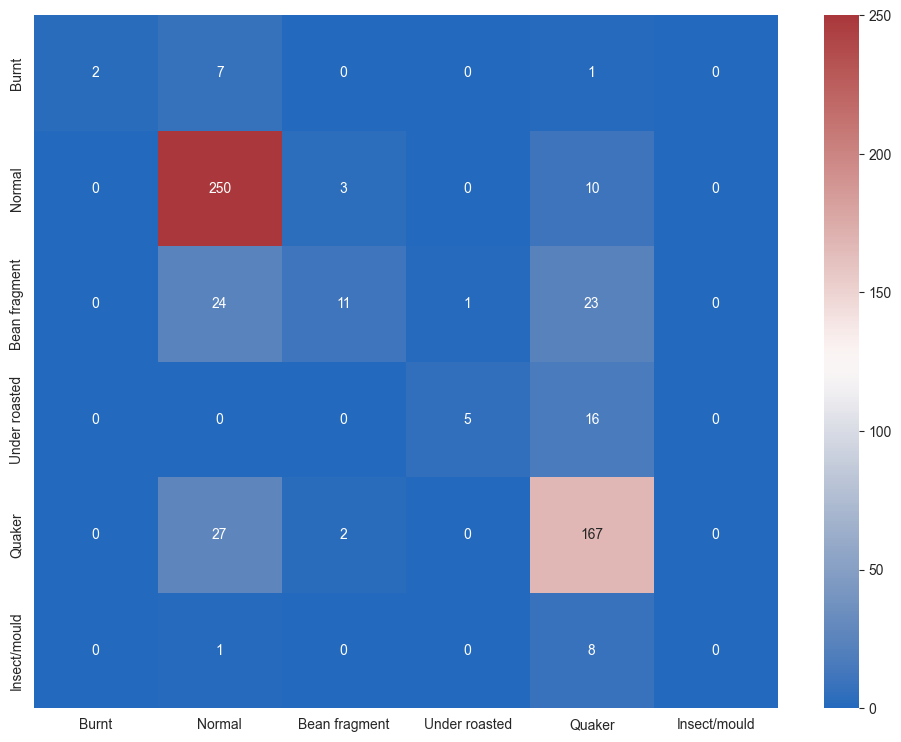

In [70]:
X_train_hists = [
    histogram(img.numpy(), nbins=32, channel_axis=0)[0].ravel() for img in X_train
]
X_test_hists = [
    histogram(img.numpy(), nbins=32, channel_axis=0)[0].ravel() for img in X_test
]

knn = KNeighborsClassifier(n_neighbors=9, metric="manhattan")
knn.fit(X_train_hists, y_train)
preds = knn.predict(X_test_hists)
print(
    classification_report(
        y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys(), digits=3
    )
)

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(preds), y_test)

confs = matrix.compute()


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    yticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)

In [43]:
import json

with open("gridsearches-knn.json", "w") as out:
    json.dump(knn_gridsearch, out)

In [44]:
manhattan = [res for res in knn_gridsearch if res["metric"] == "manhattan"]
euclidean = [res for res in knn_gridsearch if res["metric"] == "euclidean"]
canberra = [res for res in knn_gridsearch if res["metric"] == "canberra"]

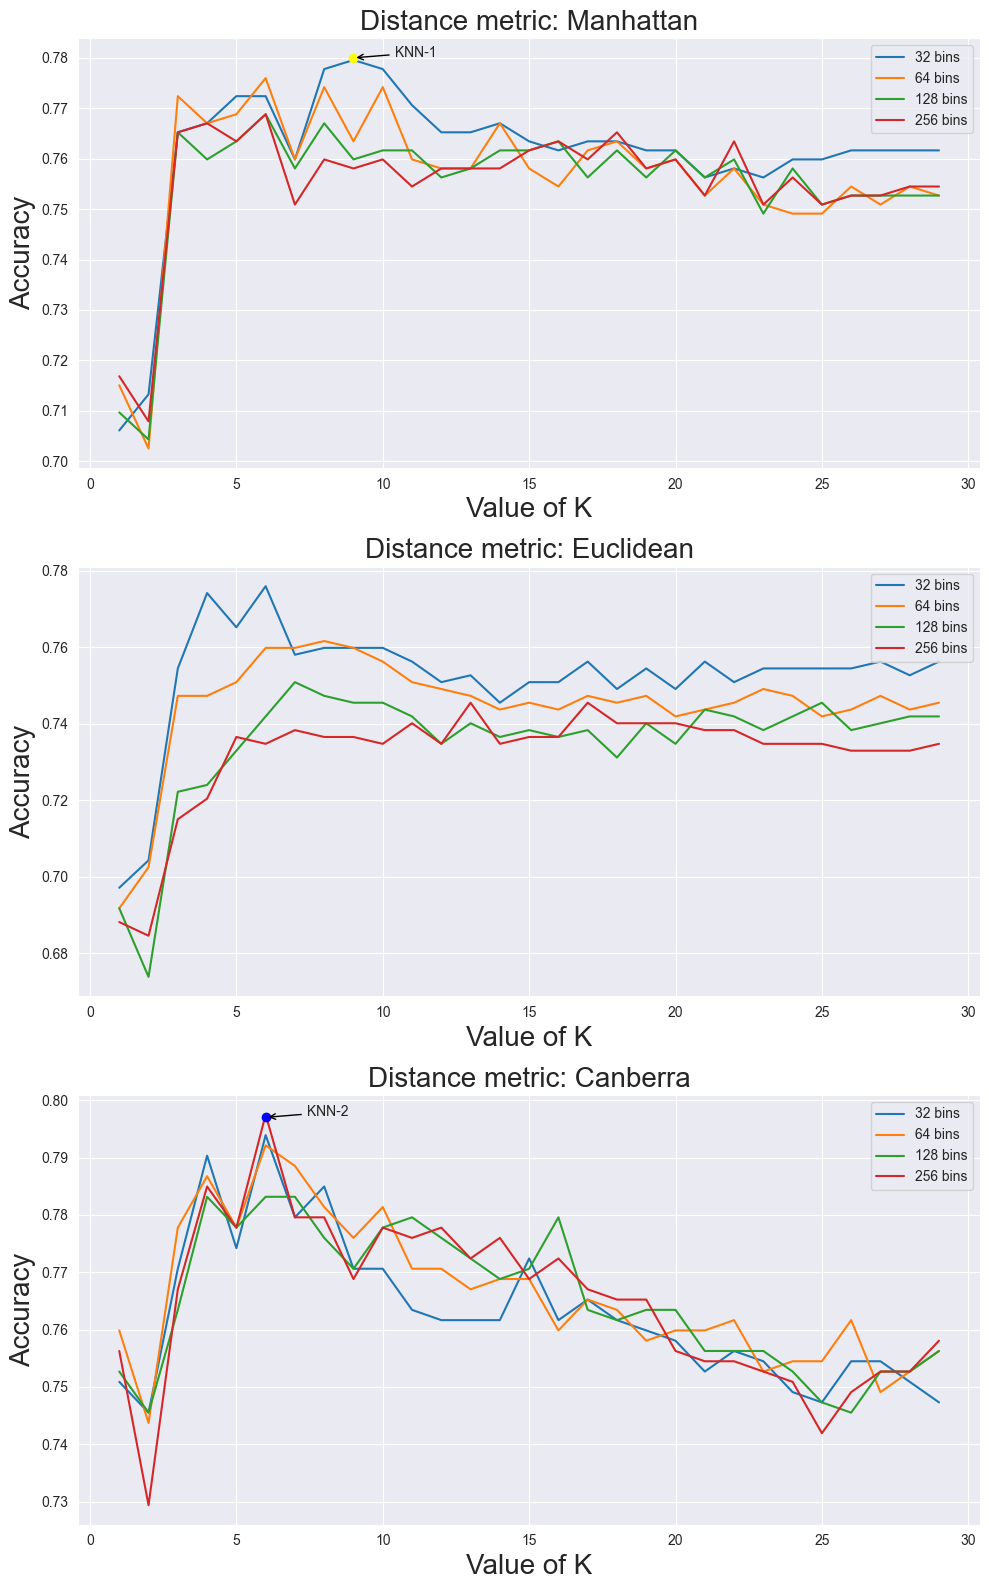

In [83]:
FONTSIZE = 20
fig, ax = plt.subplots(3, 1, figsize=(10, 16))
for bin_count in [32, 64, 128, 256]:
    for idx, results in enumerate([manhattan, euclidean, canberra]):
        ax[idx].plot(
            [res["k"] for res in results if res["bins"] == bin_count],
            [res["acc"] for res in results if res["bins"] == bin_count],
            label=f"{bin_count} bins",
        )
        ax[idx].set_xlabel("Value of K", fontsize=FONTSIZE)
        ax[idx].set_ylabel("Accuracy", fontsize=FONTSIZE)
        ax[idx].set_title(
            f'Distance metric: {results[0]["metric"].capitalize()}', fontsize=FONTSIZE
        )
        ax[idx].legend()

ax[0].scatter([9], [0.78], color="yellow", marker="o", zorder=2)
ax[2].scatter([6], [0.797], color="blue", marker="o", zorder=2)

ax[0].annotate(
    "KNN-1",
    xy=(9, 0.78),
    xycoords="data",
    xytext=(30, 0.77),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="black"),
)
ax[2].annotate(
    "KNN-2",
    xy=(6, 0.797),
    xycoords="data",
    xytext=(30, 0.77),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color="black"),
)
fig.tight_layout()
fig.savefig("../report/figures/gridsearches/knn.png", bbox_inches="tight")